In [15]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')

In [2]:
cov = [[1,   0.5,   0],
       [0.5,   1,   0],
       [0,     0,   1]]
print(np.array(cov))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.   0. ]
 [ 0.   0.   1. ]]


In [3]:
ami = np.zeros([3, 3])
for i, j in [(0, 1), (0, 2), (1, 2)]:
    ami[j, i] = ami[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200)
    print('(%d, %d): %f' % (i, j, ami[i, j]))

(0, 1): 0.147875
(0, 2): 0.003164
(1, 2): 0.002453


In [4]:
ami3 = mlmi3.mutual_information(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1), X[:, 2:], n_b=200, maxiter=1000)
print('(0, 1, 2): %f' % ami3)

(0, 1, 2): 0.148342


In [5]:
print('I(X, Y | Z) = %f' % (ami3 - ami[0, 2] - ami[1, 2]))
print('I(X, Z | Y) = %f' % (ami3 - ami[0, 1] - ami[2, 1]))
print('I(Y, Z | X) = %f' % (ami3 - ami[1, 0] - ami[2, 0]))

I(X, Y | Z) = 0.142725
I(X, Z | Y) = -0.001986
I(Y, Z | X) = -0.002698


In [6]:
pre = [[1,   0.5,    0,    0],
       [0.5,   1,  0.4,    0],
       [0,   0.4,    1, -0.3],
       [0,     0, -0.3,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0.   0. ]
 [ 0.5  1.   0.4  0. ]
 [ 0.   0.4  1.  -0.3]
 [ 0.   0.  -0.3  1. ]]


In [8]:
mi = np.zeros([4, 4])
cmi = np.zeros([4, 4])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=1000)
    mask = (np.arange(4) != i) & (np.arange(4) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 6/6 [02:26<00:00, 23.68s/it]


array([[ 0.        ,  0.12415129, -0.01300995, -0.00502973],
       [ 0.        ,  0.        ,  0.07700725, -0.01942818],
       [ 0.        ,  0.        ,  0.        ,  0.04010155],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

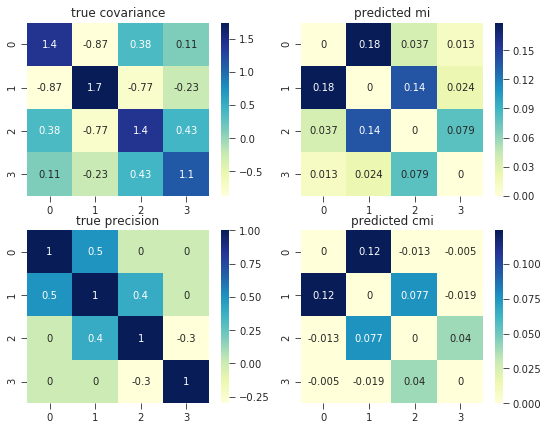

In [17]:
f, axes = plt.subplots(2, 2, figsize=[9, 7])
axes[0, 0].set_title('true covariance')
axes[0, 1].set_title('predicted mi')
axes[1, 0].set_title('true precision')
axes[1, 1].set_title('predicted cmi')
sns.heatmap(cov, annot=True, ax=axes[0, 0])
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[0, 1], vmin=0)
sns.heatmap(pre, annot=True, ax=axes[1, 0])
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[1, 1], vmin=0)
plt.savefig('cmi.png', dpi=120)

In [19]:
import os
if not os.path.exists('water-treatment.csv'):
    !wget -O water-treatment.csv https://archive.ics.uci.edu/ml/machine-learning-databases/water-treatment/water-treatment.data

--2017-09-06 16:19:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/water-treatment/water-treatment.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92549 (90K) [text/plain]
Saving to: ‘water-treatment.csv’

water-treatment.csv 100%[===================>]  90.38K   290KB/s    in 0.3s    

2017-09-06 16:19:16 (290 KB/s) - ‘water-treatment.csv’ saved [92549/92549]



In [43]:
df_raw = pd.read_csv('water-treatment.csv', header=None, na_values='?')
df = df_raw.drop(df_raw.columns[0], axis=1).dropna()
df = (df - df.mean()) / df.std()
print('Number of records: ', len(df_raw), '->', len(df))
df[:5]

Number of records:  527 -> 380


,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
3,-0.342789,0.525093,0.315869,0.250450,1.561485,-0.294765,0.374517,-0.063891,2.442977,-0.227956,...,0.932863,-0.403717,0.409139,0.521996,0.460589,0.347041,0.123252,0.481069,-0.002119,0.207640
8,-1.199077,0.095652,-0.529415,0.266743,0.399040,-0.277827,0.650968,-0.063891,-0.557492,-0.674468,...,-0.373482,0.467183,-1.180861,0.207854,0.215397,-0.993873,0.490159,-0.551941,0.096486,0.062419
9,0.273558,-0.119068,-0.106773,-0.287239,0.865715,-0.227013,0.643069,0.108054,1.007529,-0.227956,...,0.349952,-1.200925,0.061808,0.017124,0.619242,-0.242581,-0.096892,-1.135287,-0.511577,0.110826
10,0.732863,-0.677341,0.315869,-0.010248,0.628135,0.027056,0.485097,0.280000,-0.148452,1.111580,...,0.243259,-2.580966,-1.011055,0.151757,-10.457656,-4.084632,-12.828564,-5.145796,-7.660418,-15.185756
14,0.518317,0.525093,-0.952057,-0.710873,-0.636129,-0.328641,-0.273166,-0.751675,-0.427920,-1.120981,...,0.165190,-0.430514,-1.975861,-0.072631,-0.217295,-0.699062,-0.463799,-0.843614,-1.875609,0.014013


In [52]:
d = len(df.columns)
cmi = np.zeros([d, d])
X = df.values
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i < j]):
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], sigma=0.5, n_b=380, maxiter=1000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], sigma=0.5, n_b=380, maxiter=1000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], sigma=0.5, n_b=380, maxiter=1000)
    cmi[j, i] = cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi


  0%|          | 3/703 [00:18<1:11:04,  6.09s/it]

Exception: Optimization failed.

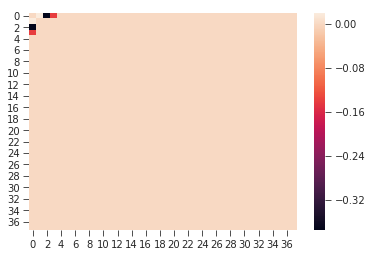

In [53]:
sns.heatmap(cmi)